# Timeseries for ERA5

This notebook computes the global monthly mean cloud amount and TIWP time series from the ERA5 reanalysis. 

In [1]:
import cmocean
from pathlib import Path 
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import cartopy.crs as ccrs
mpl.style.use("ccic.mplstyle")

In [2]:
data_path = Path('/scratch/ccic_record/data/')
ds = xr.open_dataset(data_path / 'ERA5' / 'era5_tcsw_tciw_tcc_1980_2023.nc') 

mask = xr.open_dataset(data_path / 'mask_24.nc')
# convert to int because interpolation does not work with bool dtype 
mask = mask.mask.astype(int)
# interpolate mask to ERA5 grid 
interpolated_mask = mask.interp(coords = {'longitude': ds.longitude.values, 'latitude': ds.latitude.values}, method = 'linear' )

## ERA5 variables: 

- **total column cloud ice water : tciw [kg m$^{-2}$]** - This parameter is the amount of ice contained within clouds in a column extending from the surface of the Earth to the top of the atmosphere. Snow (aggregated ice crystals) is not included in this parameter. This parameter represents the area averaged value for a model grid box. Clouds contain a continuum of different sized water droplets and ice particles. The ECMWF Integrated Forecasting System (IFS) cloud scheme simplifies this to represent a number of discrete cloud droplets/particles including: cloud water droplets, raindrops, ice crystals and snow (aggregated ice crystals). The processes of droplet formation, phase transition and aggregation are also highly simplified in the IFS.

- **total column snow water : tcsw [kg m$^{-2}$]** - This parameter is the total amount of water in the form of snow (aggregated ice crystals which can fall to the surface as precipitation) in a column extending from the surface of the Earth to the top of the atmosphere. This parameter represents the area averaged value for a grid box. Clouds contain a continuum of different sized water droplets and ice particles. The ECMWF Integrated Forecasting System (IFS) cloud scheme simplifies this to represent a number of discrete cloud droplets/particles including: cloud water droplets, raindrops, ice crystals and snow (aggregated ice crystals). The processes of droplet formation, conversion and aggregation are also highly simplified in the IFS.


- **total cloud cover : tcc [kg m$^{-2}$]** - This parameter is the proportion of a grid box covered by cloud. Total cloud cover is a single level field calculated from the cloud occurring at different model levels through the atmosphere. Assumptions are made about the degree of overlap/randomness between clouds at different heights. Cloud fractions vary from 0 to 1.


Note that we define the **total ice water path (tiwp)** as the sum of tciw and tcsw. 

In [ ]:
# combine months from ERA5 with ERA5T
ERA5_combined =ds.sel(expver=1).combine_first(ds.sel(expver=5))

# add snow and column ice to get total ice water path 
tiwp= ERA5_combined.tcsw + ERA5_combined.tciw

# total cloud cover fraction
ca= ERA5_combined.tcc

## Calculate global means of tiwp and cloud cover fraction with latitude weights and mask 

In [31]:
def get_global_mean(data, latname, lonname):
    weights = np.cos(np.deg2rad(data[latname]))
    weights.name = "weights"
    weighted_data = data.weighted(weights)
    global_mean = weighted_data.mean((lonname, latname))
    return global_mean

In [32]:
tiwp_global_mean = get_global_mean(tiwp.where(mask == 1 ),'latitude', 'longitude')
ca_global_mean = get_global_mean(ca.where(mask == 1 ),'latitude', 'longitude')

# save timeseries as nc files 
tiwp_global_mean.to_netcdf('/scratch/ccic_record/data/ERA5/era5_tiwp_timeseries.nc')
ca_global_mean.to_netcdf('/scratch/ccic_record/data/ERA5/era5_ca_timeseries.nc')

## Time series of monthly global mean cloud amount and total ice water path 

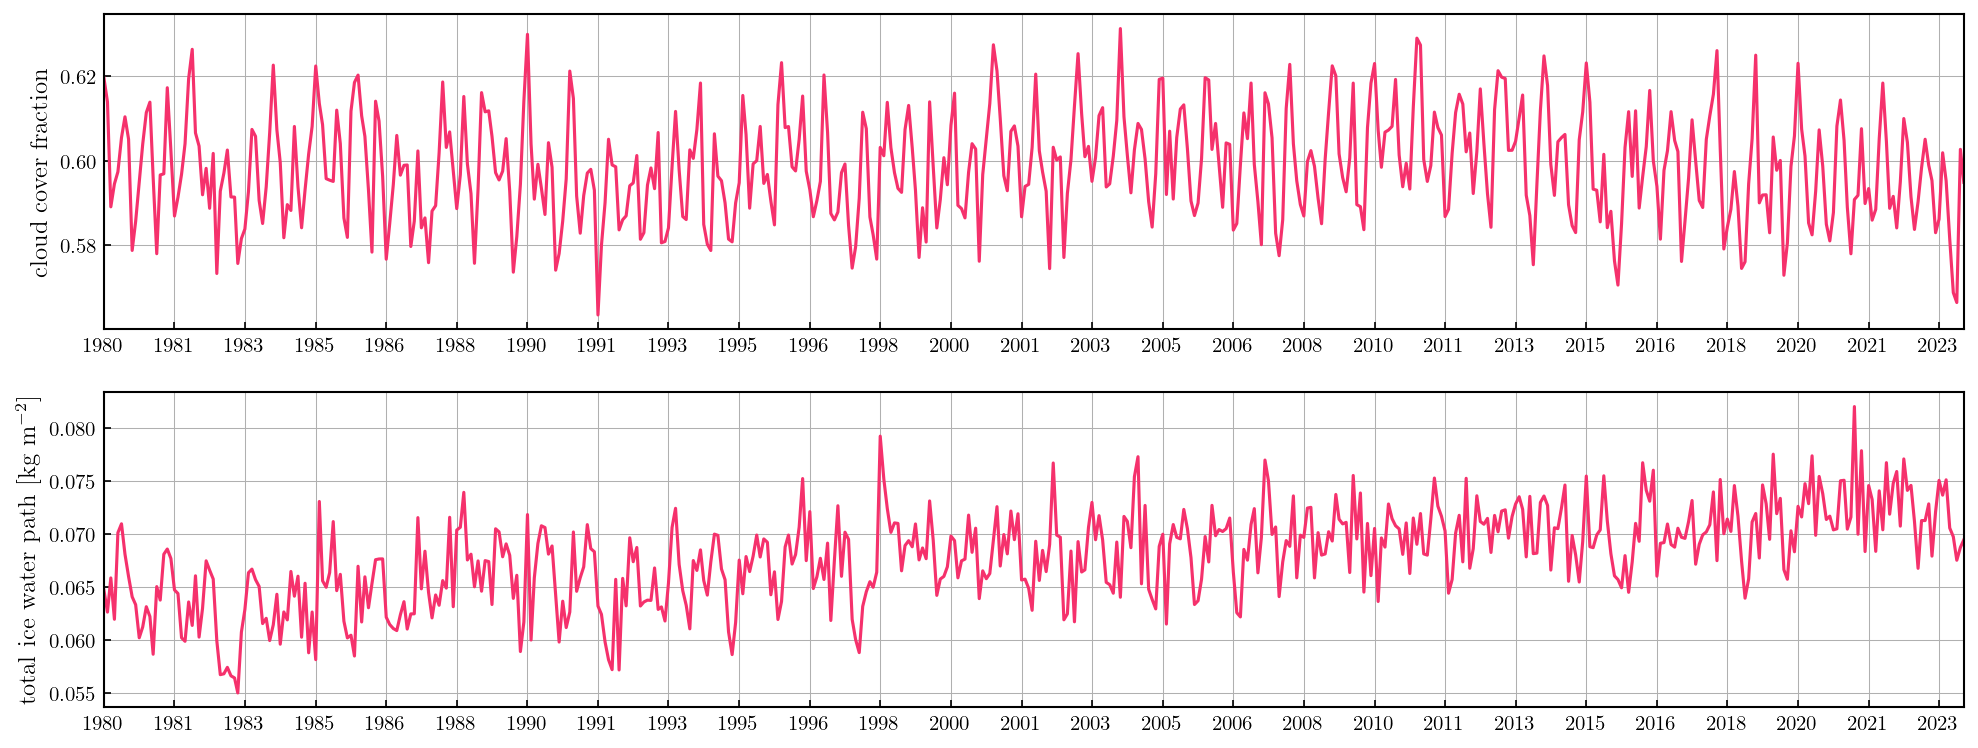

In [36]:
plt.figure(figsize=(16,6))

fs = 12

# monthly timeseries cloud amount 
plt.subplot(2,1,1)
plt.plot(ca_global_mean.time, ca_global_mean)
plt.xticks(ca.time[::20], ca.time.dt.year.values[::20])
plt.xlim(ca_global_mean.time[0], ca_global_mean.time[-1])
plt.ylabel(r'cloud cover fraction', fontsize = fs)
plt.grid()


# monthly timeseries ice water path 
plt.subplot(2,1,2)
plt.plot(tiwp_global_mean.time, tiwp_global_mean)
plt.ylabel(r'total ice water path [kg m$^{-2}]$', fontsize = fs)
plt.xticks(tiwp.time[::20], tiwp.time.dt.year.values[::20])
plt.xlim(ca_global_mean.time[0], ca_global_mean.time[-1])
plt.grid()

plt.show()

## Global maps of cloud amount and total ice water path 

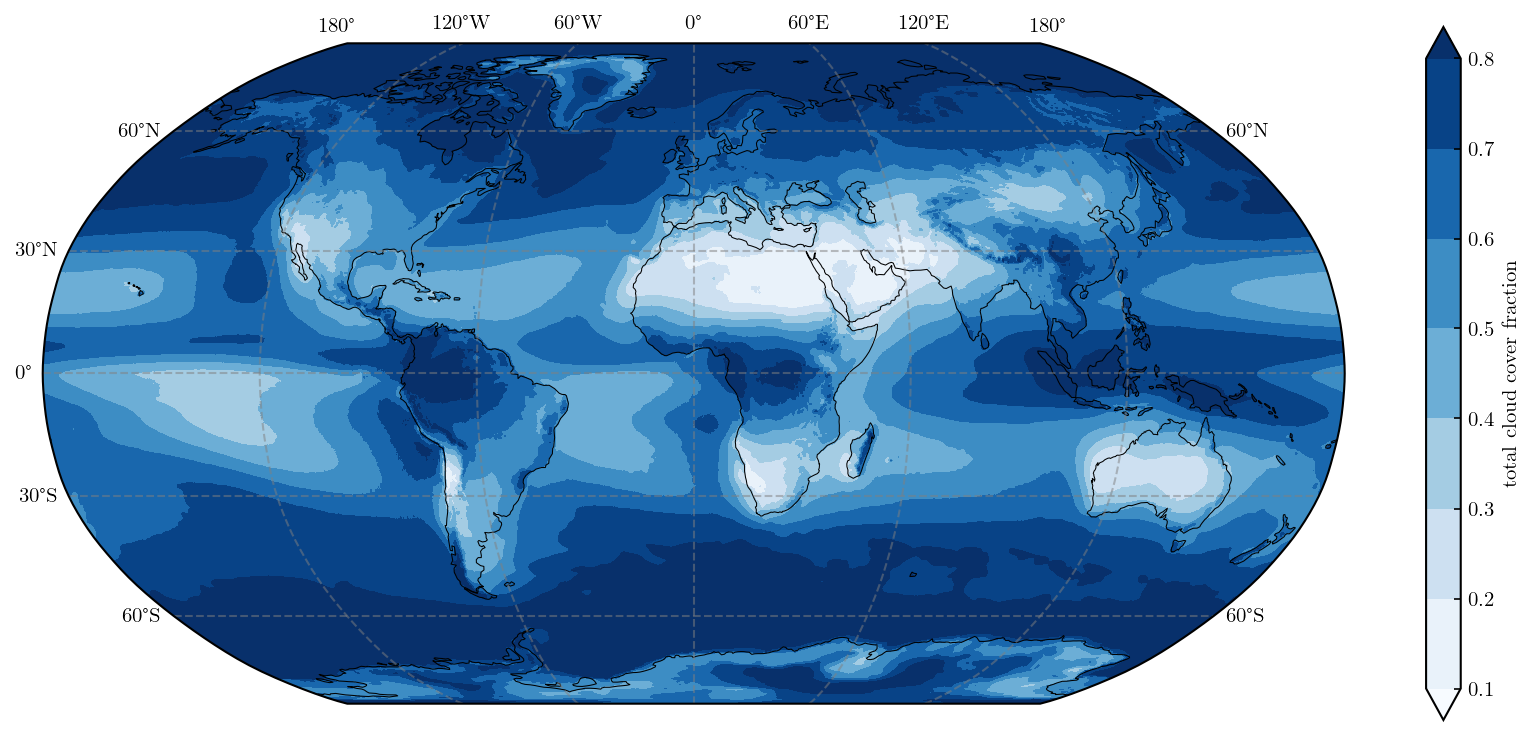

In [30]:
fig = plt.figure(figsize=(14,6))

nrows = 1 
ncols = 1 
lons = ca.longitude
lats = ca.latitude
data = ca.mean('time')

ax = plt.subplot2grid(shape=(nrows, ncols), loc=(0, 0), colspan=1, projection=ccrs.Robinson())

cs=ax.contourf(lons, lats, data,
                  transform = ccrs.PlateCarree(),
                  levels = np.arange(0.1,0.9, 0.1),
                  cmap=plt.cm.Blues,extend='both')

ax.coastlines(resolution='110m')

gl = ax.gridlines(crs=ccrs.PlateCarree(),
          draw_labels=True,
          linewidth=1,
          color='gray',
          alpha=0.5,
          linestyle='--') 

gl.bottom_labels = False
gl.right_labels = False 
plt.colorbar(cs, label = 'total cloud cover fraction') 
plt.show()

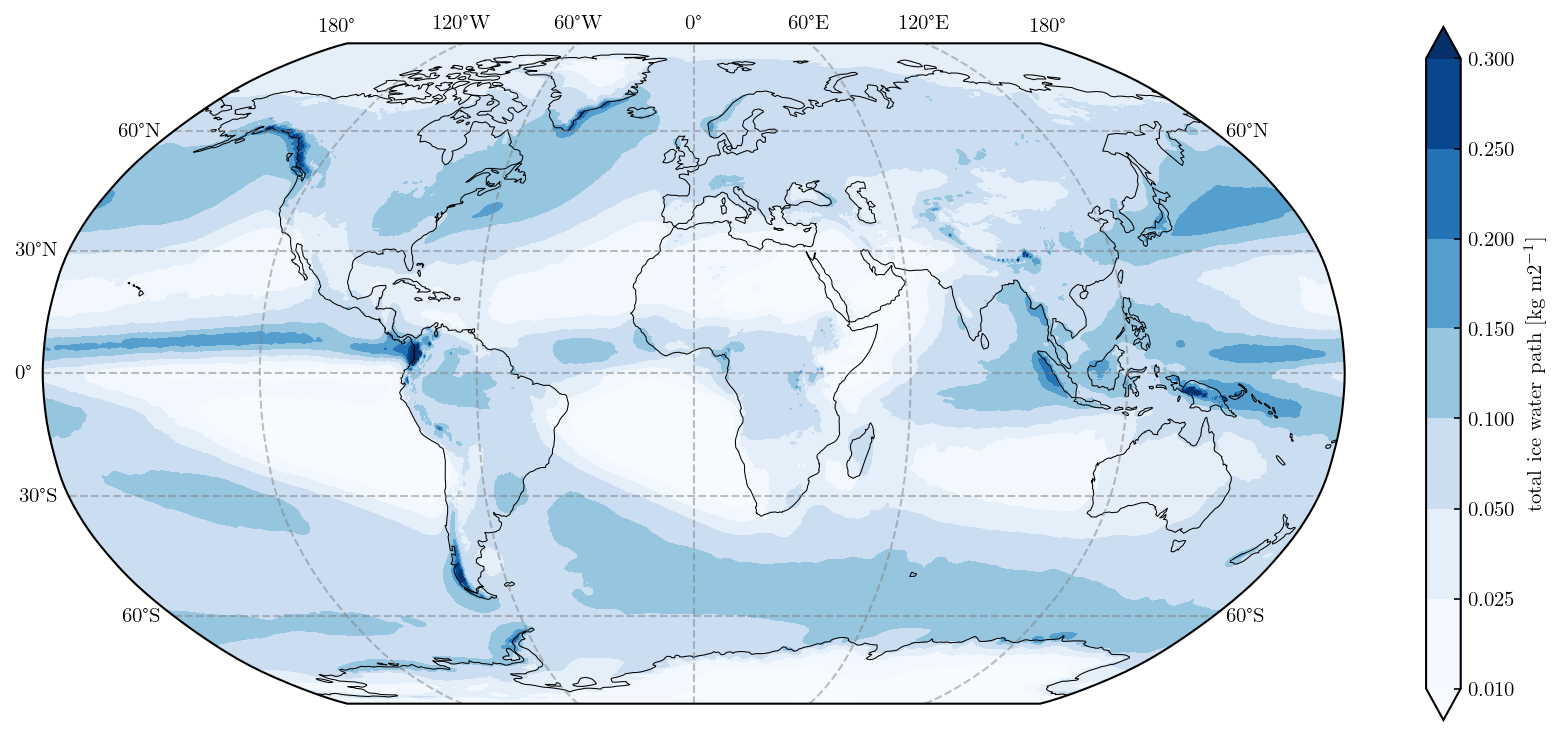

In [28]:
fig = plt.figure(figsize=(14,6))

nrows = 1 
ncols = 1 
lons = tiwp.longitude
lats = tiwp.latitude
data = tiwp.mean('time')

ax = plt.subplot2grid(shape=(nrows, ncols), loc=(0, 0), colspan=1, projection=ccrs.Robinson())

cs=ax.contourf(lons, lats, data,
                  transform = ccrs.PlateCarree(),
                  levels = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                  cmap=plt.cm.Blues,extend='both')

ax.coastlines(resolution='110m')

gl = ax.gridlines(crs=ccrs.PlateCarree(),
          draw_labels=True,
          linewidth=1,
          color='gray',
          alpha=0.5,
          linestyle='--') 

gl.bottom_labels = False
gl.right_labels = False 
plt.colorbar(cs, label = 'total ice water path [kg m2$^{-1}$]') 
plt.show()